# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
We saw before than SMA and SE-MA strategies did not do well on the TSLA price. Which was kind of expected from the beginning as they are both simple strategies that cannot do well with high volatility. But it was definetly fun optimizing using Bayesian Optimization. 

We also saw that GMM model as a risk manager did improve on the strategies, but was not able to predict the fast sudden decrease in the price at 2017-07. 

In this approach we will try using multiple classifiers to predict the movement of the price (Up or Down). We will use Support Vector Machine, Random Forest and K Nearest Neighbour.

The strategy will be as follows:
```
Fit the classifiers on the training set
At every trading day Predict the movement of the price using all 3 classifiers
IF NOT Invested AND 2 or more classifiers predict Up THEN
    BUY
IF Invested AND 2 or more classifiers predict Down THEN
    SELL
```

## Training Data Set
We already extracted data before so we will start by loading the data and preparing the training data set. 
Although our data has 30 days return as input for every day, we will only use 5 days return as input.  

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//to show the full output without scrolling

<IPython.core.display.Javascript object>

In [2]:
## to use zipline magic commands (which is not used in this notebook)
%load_ext zipline
## inline plot
%matplotlib inline

##import libraries
import zipline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('seaborn-darkgrid')

import pickle
import numpy as np
from zipline.api import (
    order_target_percent, 
    record, 
    symbol, 
    schedule_function, 
    sid,
    date_rules,
    time_rules,
    get_open_orders,
    order_percent,
    order,
    set_benchmark)
from zipline.finance import commission, slippage
from zipline import run_algorithm

## pyfolio was not installed in the docker image (needs updating)
## if you want to use pyfolio to analyze the portfolio
try:
    import pyfolio as pf
except:    
    !pip install pyfolio
    import pyfolio as pf


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm, neighbors
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [3]:
##load data
df = pd.read_pickle('data/TSLAtraining.pickle')


In [4]:
X = df['X_return'].values
X = np.array([np.array(x) for x in X])[:,-30:]
y = df['label'].values

In [5]:
X.shape, y.shape

((499, 30), (499,))

In [6]:
down = y[[True if i == 0 else False for i in y]]
up = y[[True if i == 1 else False for i in y]]
len(down), len(up)

(249, 250)

Our classes are well balanced. So we don't have a problem there. However, that actually show us how much the TSLA price is volatile. 

## Support Vector Machine 
We will use RBF kernel with our SVC model. We will test for different C and gamma values using k fold cross validiation with 5 folds. 

I did some trial and error on different ranges for C and gamma and found it's best to bound the parameters between 0.5 and 2. 

In [7]:
C_s = np.linspace(0.5, 2, 15)
gamma_s = np.linspace(0.5, 2, 15)

parameters = {'kernel':('rbf',), 'C':C_s, 'gamma':gamma_s}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5,return_train_score=True)
clf.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([0.5    , 0.60714, 0.71429, 0.82143, 0.92857, 1.03571, 1.14286,
       1.25   , 1.35714, 1.46429, 1.57143, 1.67857, 1.78571, 1.89286,
       2.     ]), 'kernel': ('rbf',), 'C': array([0.5    , 0.60714, 0.71429, 0.82143, 0.92857, 1.03571, 1.14286,
       1.25   , 1.35714, 1.46429, 1.57143, 1.67857, 1.78571, 1.89286,
       2.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [8]:
clf.best_estimator_

SVC(C=1.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.5714285714285714,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [9]:
score = pd.DataFrame(clf.cv_results_)

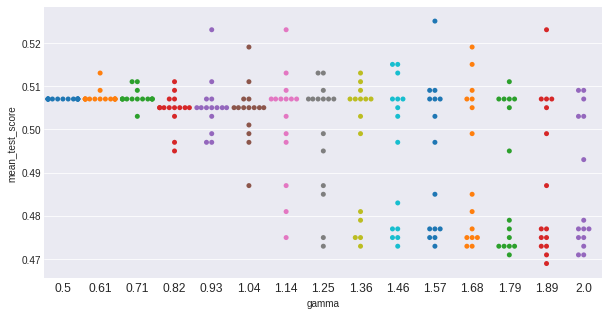

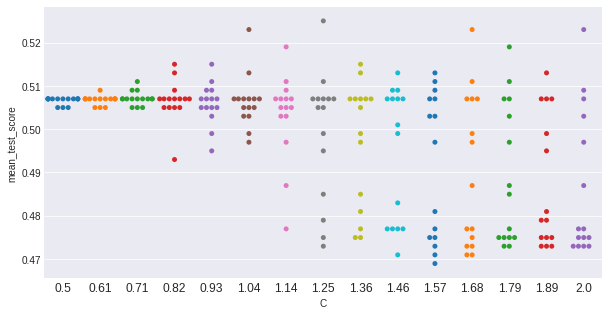

In [10]:
#plt.figure(figsize=(20,30))
for i in parameters.keys():
    #print(i, len(parameters[i]), parameters[i])
    score[i] = score.params.apply(lambda x: x[i])
l =['mean_test_score'] + list(parameters.keys())
for i in list(parameters.keys()):
    if i == 'kernel':
        continue
    plt.figure(figsize=(10,5))
    sns.swarmplot(data = score[l],x=i, y = 'mean_test_score',palette=sns.color_palette())
    locs, labels = plt.xticks()
    plt.xticks(locs, [round(float(x.get_text()),2) for x in labels],fontsize=12)
    plt.show()


In [11]:
print("The best parameters are at C="+str(round(clf.best_estimator_.C,2))+" and gamma=" +
      str(round(clf.best_estimator_.gamma,2))+".")

The best parameters are at C=1.25 and gamma=1.57.


We will fit the SVC model on all the training data and pickle it to be used later on in our strategy. 

In [12]:
svc = svm.SVC()
svc.C = clf.best_estimator_.C
svc.gamma = clf.best_estimator_.gamma
svc.fit(X,y)

SVC(C=1.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.5714285714285714,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [13]:
pickle.dump(svc,open('models/svc.pickle','wb'))

## K-Nearest Neighbour
We will apply the same cross validation method to find a good K for our classifier model. 

In [14]:
k_s = [x for x in range(2,21)]

parameters = {'n_neighbors':k_s}
knn = neighbors.KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=5,return_train_score=True)
clf.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

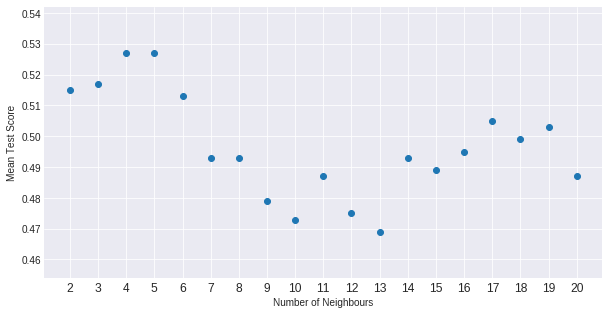

In [16]:
score = pd.DataFrame(clf.cv_results_)
for i in parameters.keys():
    #print(i, len(parameters[i]), parameters[i])
    score[i] = score.params.apply(lambda x: x[i])
l =['mean_test_score'] + list(parameters.keys())
for i in list(parameters.keys()):
    plt.figure(figsize=(10,5))
    plt.scatter(y = score['mean_test_score'],x=score['param_n_neighbors'],color='C0')
    locs, labels = plt.xticks()
    plt.xticks(score['param_n_neighbors'], score['param_n_neighbors'],fontsize=12)
    plt.xlabel("Number of Neighbours")
    plt.ylabel('Mean Test Score')
    plt.show()

In [17]:
print("The best parameters are at K="+str(clf.best_estimator_.n_neighbors)+".")

The best parameters are at K=4.


We will fit the KNN model on all the training data and pickle it to be used later on in our strategy. 

In [18]:
knn = neighbors.KNeighborsClassifier()
knn.n_neighbors = clf.best_estimator_.n_neighbors
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [19]:
pickle.dump(svc,open('models/knn.pickle','wb'))

## Random Forest Classifier
We will apply the same cross validation method to find a good number of estimators for our random forst model.

In [35]:
ne_s = [x for x in range(1,11,1)]

parameters = {'n_estimators':ne_s}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=5,return_train_score=True)
clf.fit(X,y)

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [36]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

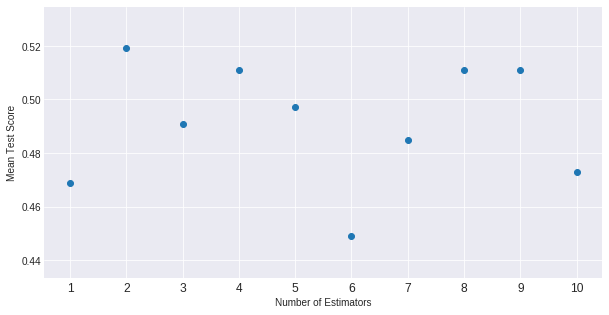

In [37]:
score = pd.DataFrame(clf.cv_results_)
for i in parameters.keys():
    #print(i, len(parameters[i]), parameters[i])
    score[i] = score.params.apply(lambda x: x[i])
l =['mean_test_score'] + list(parameters.keys())
for i in list(parameters.keys()):
    plt.figure(figsize=(10,5))
    plt.scatter(y = score['mean_test_score'],x=score['param_n_estimators'],color='C0')
    locs, labels = plt.xticks()
    plt.xticks(score['param_n_estimators'], score['param_n_estimators'],fontsize=12)
    plt.xlabel("Number of Estimators")
    plt.ylabel('Mean Test Score')
    plt.show()

In [38]:
print("The best parameters are at n_estimator="+str(clf.best_estimator_.n_estimators)+".")

The best parameters are at n_estimator=2.


We will fit the Random Forest model on all the training data and pickle it to be used later on in our strategy. 

In [39]:
rf = RandomForestClassifier()
rf.n_estimators = clf.best_estimator_.n_estimators
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
pickle.dump(svc,open('models/rf.pickle','wb'))

In [ ]:
##TODO understand random forest and tune parameters better

## Conclusion
In general the classifiers did not do so well! We had an average of 50% test score between the 3 classifiers.
But maybe the strategy would do better than the previous strategies we have? Or will this project be a failure? 